In [1]:
import pandas as pd
import numpy as np
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS 
from neuralforecast.losses.pytorch import DistributionLoss
from sklearn.metrics import mean_absolute_error
import optuna
import matplotlib.pyplot as plt

In [2]:
path = '../../Data/Kaggle/StoreSales/processed_train_v2.csv'
data = pd.read_csv(path, index_col='id', parse_dates=['date'])

In [3]:
data.head()

,date,store_nbr,family,sales,onpromotion,typeholiday,dcoilwtico,city,state,typestores,cluster,day_of_week,day,month,year
id,,,,,,,,,,,,,,,
0,2013-01-01,1,0,0.0,0,3,93.14,18,12,3,13,2,1,1,2013
1,2013-01-01,1,1,0.0,0,3,93.14,18,12,3,13,2,1,1,2013
2,2013-01-01,1,2,0.0,0,3,93.14,18,12,3,13,2,1,1,2013
3,2013-01-01,1,3,0.0,0,3,93.14,18,12,3,13,2,1,1,2013
4,2013-01-01,1,4,0.0,0,3,93.14,18,12,3,13,2,1,1,2013


In [4]:
data2 = data.loc[(data['store_nbr'] == 1) & (data['family'].isin([3])), ['date', 'family', 'sales', 'onpromotion']]

In [5]:
data2.head()

,date,family,sales,onpromotion
id,,,,
3,2013-01-01,3,0.0,0
1785,2013-01-02,3,1091.0,0
3567,2013-01-03,3,919.0,0
5349,2013-01-04,3,953.0,0
7131,2013-01-05,3,1160.0,0


In [6]:
dec25 = list()
for year in range(2013,2017):
    for family in [3]:
        dec18 = data2.loc[(data2['date'] == f'{year}-12-18') & (data2['family'] == family)]
        dec25 += [{'date': pd.Timestamp(f'{year}-12-25'), 'family': family, 'sales': dec18['sales'].values[0], 'onpromotion': dec18['onpromotion'].values[0]}]
data2 = pd.concat([data2, pd.DataFrame(dec25)], ignore_index=True).sort_values('date')

In [7]:
data2 = data2.rename(columns={'date': 'ds', 'sales': 'y', 'family': 'unique_id'})

In [8]:
train = data2.loc[data2['ds'] < '2017-01-01']
valid = data2.loc[(data2['ds'] >= '2017-01-01') & (data2['ds'] < '2017-04-01')]
h = valid['ds'].nunique()

In [9]:
models = [NBEATS(h=h,input_size=7,
                 loss=DistributionLoss(distribution='Poisson', level=[90]),
                 max_steps=100,
                 scaler_type='standard',
               futr_exog_list=['onpromotion'])]

model = NeuralForecast(models=models, freq='D')
model.fit(train)

p =  model.predict(futr_df=valid).reset_index()
p = p.merge(valid[['ds','unique_id', 'y']], on=['ds', 'unique_id'], how='left')

Seed set to 1


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

In [10]:
model.fit(train)

p =  model.predict(futr_df=valid).reset_index()
p = p.merge(valid[['ds','unique_id', 'y']], on=['ds', 'unique_id'], how='left')

Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

In [11]:
def objective(trial):
    input_size = trial.suggest_int('input_size', 1, 60)
    
    n_blocks_season = trial.suggest_int('n_blocks_season', 1, 3)
    n_blocks_trend = trial.suggest_int('n_blocks_trend', 1, 3)
    n_blocks_identity = trial.suggest_int('n_blocks_ident', 1, 3)
    
    mlp_units_n = trial.suggest_categorical('mlp_units', [32, 64, 128])
    num_hidden = trial.suggest_int('num_hidden', 1, 3)
    
    n_harmonics = trial.suggest_int('n_harmonics', 1, 5)
    n_polynomials = trial.suggest_int('n_polynomials', 1, 5)
    
    scaler_type = trial.suggest_categorical('scaler_type', ['standard', 'robust'])
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-1)
    
    
    n_blocks = [n_blocks_season, n_blocks_trend, n_blocks_identity]
    mlp_units=[[mlp_units_n, mlp_units_n]]*num_hidden
    models = [NBEATS(h=h,input_size=input_size,
                 loss=DistributionLoss(distribution='Poisson', level=[90]),
                 max_steps=100,
                 futr_exog_list=['onpromotion'],
                 stack_types=['seasonality', 'trend', 'identity'],
                 mlp_units=mlp_units,
                 n_blocks=n_blocks,
                 learning_rate=learning_rate,
                 n_harmonics=n_harmonics,
                 n_polynomials=n_polynomials,
                 scaler_type=scaler_type)
                 ]
    model = NeuralForecast(models=models, freq='D')
    model.fit(train)

    p = model.predict(futr_df=valid).reset_index()
    p = p.merge(valid[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'], how='left')

    loss = mean_absolute_error(p['y'], p['NBEATS']) 

    return loss

In [12]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)

[I 2024-02-05 19:02:37,423] A new study created in memory with name: no-name-df24161d-98b9-4689-a282-76a9456b877c
Seed set to 1


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2024-02-05 19:02:41,474] Trial 0 finished with value: 713.8288370768229 and parameters: {'input_size': 3, 'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 1.3683968195867383e-05}. Best is trial 0 with value: 713.8288370768229.
Seed set to 1


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2024-02-05 19:02:45,045] Trial 1 finished with value: 624.4558607313368 and parameters: {'input_size': 27, 'n_blocks_season': 1, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 1, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 5.453395670914576e-05}. Best is trial 1 with value: 624.4558607313368.
Seed set to 1


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2024-02-05 19:02:49,783] Trial 2 finished with value: 1032.0766733805337 and parameters: {'input_size': 58, 'n_blocks_season': 2, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 5, 'n_polynomials': 2, 'scaler_type': 'standard', 'learning_rate': 2.0520130732724576e-05}. Best is trial 1 with value: 624.4558607313368.
Seed set to 1


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2024-02-05 19:02:55,135] Trial 3 finished with value: 2213.2555555555555 and parameters: {'input_size': 43, 'n_blocks_season': 3, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 1, 'n_harmonics': 2, 'n_polynomials': 4, 'scaler_type': 'robust', 'learning_rate': 0.08565525175414966}. Best is trial 1 with value: 624.4558607313368.
Seed set to 1


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2024-02-05 19:02:59,671] Trial 4 finished with value: 14410.106315104167 and parameters: {'input_size': 13, 'n_blocks_season': 3, 'n_blocks_trend': 2, 'n_blocks_ident': 1, 'mlp_units': 128, 'num_hidden': 1, 'n_harmonics': 4, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.00017678223965341333}. Best is trial 1 with value: 624.4558607313368.
Seed set to 1


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2024-02-05 19:03:03,585] Trial 5 finished with value: 741.649365234375 and parameters: {'input_size': 3, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 2, 'n_harmonics': 3, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.0004400276786417484}. Best is trial 1 with value: 624.4558607313368.
Seed set to 1


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2024-02-05 19:03:08,269] Trial 6 finished with value: 649.6083997938368 and parameters: {'input_size': 45, 'n_blocks_season': 2, 'n_blocks_trend': 1, 'n_blocks_ident': 1, 'mlp_units': 32, 'num_hidden': 3, 'n_harmonics': 3, 'n_polynomials': 5, 'scaler_type': 'robust', 'learning_rate': 2.689174762752845e-05}. Best is trial 1 with value: 624.4558607313368.
Seed set to 1


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2024-02-05 19:03:13,919] Trial 7 finished with value: 2213.2555555555555 and parameters: {'input_size': 53, 'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 2, 'mlp_units': 128, 'num_hidden': 3, 'n_harmonics': 5, 'n_polynomials': 3, 'scaler_type': 'standard', 'learning_rate': 0.014240385085809321}. Best is trial 1 with value: 624.4558607313368.
Seed set to 1


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2024-02-05 19:03:18,911] Trial 8 finished with value: 1878.3582478841147 and parameters: {'input_size': 46, 'n_blocks_season': 3, 'n_blocks_trend': 3, 'n_blocks_ident': 1, 'mlp_units': 64, 'num_hidden': 2, 'n_harmonics': 4, 'n_polynomials': 5, 'scaler_type': 'standard', 'learning_rate': 0.00015551942963998777}. Best is trial 1 with value: 624.4558607313368.
Seed set to 1


Sanity Checking: |                                        | 0/? [00:00<?, ?it/s]

Training: |                                               | 0/? [00:00<?, ?it/s]

Validation: |                                             | 0/? [00:00<?, ?it/s]

Predicting: |                                             | 0/? [00:00<?, ?it/s]

[I 2024-02-05 19:03:25,286] Trial 9 finished with value: 524.6181206597222 and parameters: {'input_size': 24, 'n_blocks_season': 2, 'n_blocks_trend': 3, 'n_blocks_ident': 3, 'mlp_units': 64, 'num_hidden': 3, 'n_harmonics': 1, 'n_polynomials': 3, 'scaler_type': 'robust', 'learning_rate': 0.0009692190709516328}. Best is trial 9 with value: 524.6181206597222.


In [13]:
study.best_params

{'input_size': 24,
 'n_blocks_season': 2,
 'n_blocks_trend': 3,
 'n_blocks_ident': 3,
 'mlp_units': 64,
 'num_hidden': 3,
 'n_harmonics': 1,
 'n_polynomials': 3,
 'scaler_type': 'robust',
 'learning_rate': 0.0009692190709516328}

In [14]:
study.best_value

524.6181206597222

Predicting: |                                             | 0/? [00:00<?, ?it/s]

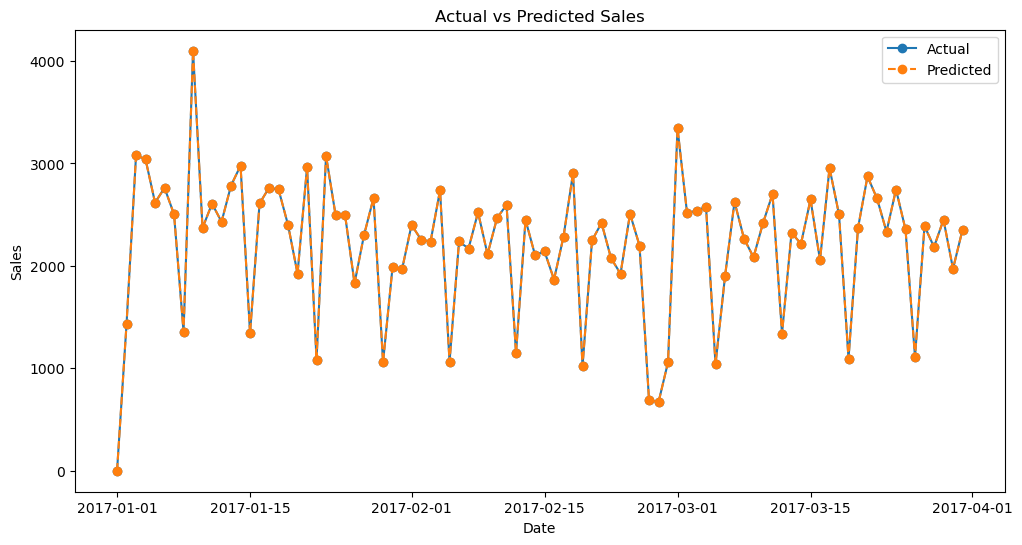

In [15]:
predictions = model.predict(futr_df=valid).reset_index()
predictions = predictions.merge(valid[['ds', 'unique_id', 'y']], on=['ds', 'unique_id'], how='left')

plt.figure(figsize=(12, 6))

plt.plot(valid['ds'], valid['y'], label='Actual', marker='o', linestyle='-')

plt.plot(predictions['ds'], predictions['y'], label='Predicted', marker='o', linestyle='--')

plt.title('Actual vs Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()